# ATLAS Based Segmentaton

Author(s): Mohammad Imran Hossain, Muhammad Zain Amin
<br> University of Girona, Spain

# Necessary Libraries

In [41]:
import utils
import numpy as np
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List
from pathlib import Path

# Affine Registration

**1. Generate ATLAS**

In [42]:
def save_atlas(
    volume: np.ndarray, reference: sitk.Image, filepath: Path
):
    # Save image
    img = sitk.GetImageFromArray(volume)
    img.SetDirection(reference.GetDirection())
    img.SetOrigin(reference.GetOrigin())
    img.SetSpacing(reference.GetSpacing())
    sitk.WriteImage(img, str(filepath))

# Define the main path
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()

# Define the path of registarted image and labels
output_dir_path     = MAIN_PATH / 'Dataset' / 'Training' / 'training-outputs' / 'Par0009.affine'
reg_image_dir_path  = output_dir_path / 'training-images'
reg_labels_dir_path = output_dir_path / 'training-labels'

# Define the path of the reference image
ref_image_path = reg_image_dir_path / 'r_1001.nii.gz'

# Read the reference image and convert into an array
ref_image = sitk.ReadImage(str(ref_image_path))  
ref_image_array = sitk.GetArrayFromImage(ref_image)

# Define the configuration for atlas
num_classes = 4
num_volumes = len(list(reg_labels_dir_path.iterdir()))
ref_image_shape = ref_image_array.shape
labels_keys = {0: 'background', 1: 'csf', 2: 'wm', 3: 'gm'}

# Create atlas accumulators
atlases     = np.zeros((num_classes, ref_image_shape[0], ref_image_shape[1], ref_image_shape[2])).astype('float32')
mean_volume = np.zeros_like(ref_image_array).astype('float32')

# Loop through each registered image for atlas creation
for i, image_path in tqdm(enumerate(reg_image_dir_path.iterdir()), total=len(list(reg_image_dir_path.iterdir()))):
    
    # If image has .txt extension, continue
    if image_path.name.endswith('txt'):
        continue
    
    # Get the id of the registered image and label
    image_id = image_path.name.rstrip('.nii.gz')
    label_id = f'{image_id}_3C.nii.gz'
    
    # Accumulate the mean of an registered image
    image = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image = ((image - image.min()) / (image.max() - image.min()) * 255).astype('uint8')
    mean_volume += image / num_volumes
    
    # Accumulate probability atlas image
    label = sitk.GetArrayFromImage(sitk.ReadImage(str(reg_labels_dir_path / label_id))) 
    for j in range(atlases.shape[0]):
        atlases[j, :, :, :] += np.where(label == j, 1, 0) / num_volumes

# Get topological atlas by voting
topological_atlas = np.argmax(atlases, axis=0)

# Save atlas results
atlas_output_path = MAIN_PATH / 'Dataset' / 'Training' / "Atlases" / "Par0009.affine"
atlas_output_path.mkdir(exist_ok=True, parents=True)

for k in range(atlases.shape[0]):
    save_atlas(atlases[k, :, :, :], ref_image, atlas_output_path / f'p_atlas_{labels_keys[k]}.nii.gz')
    save_atlas(np.where(topological_atlas == k, 255, 0), ref_image, atlas_output_path / f't_atlas_{labels_keys[k]}.nii.gz')

    save_atlas(topological_atlas, ref_image, atlas_output_path / 't_atlas.nii.gz')
    save_atlas(mean_volume, ref_image, atlas_output_path / 'mean_volume.nii.gz')

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:40<00:00,  1.39s/it]


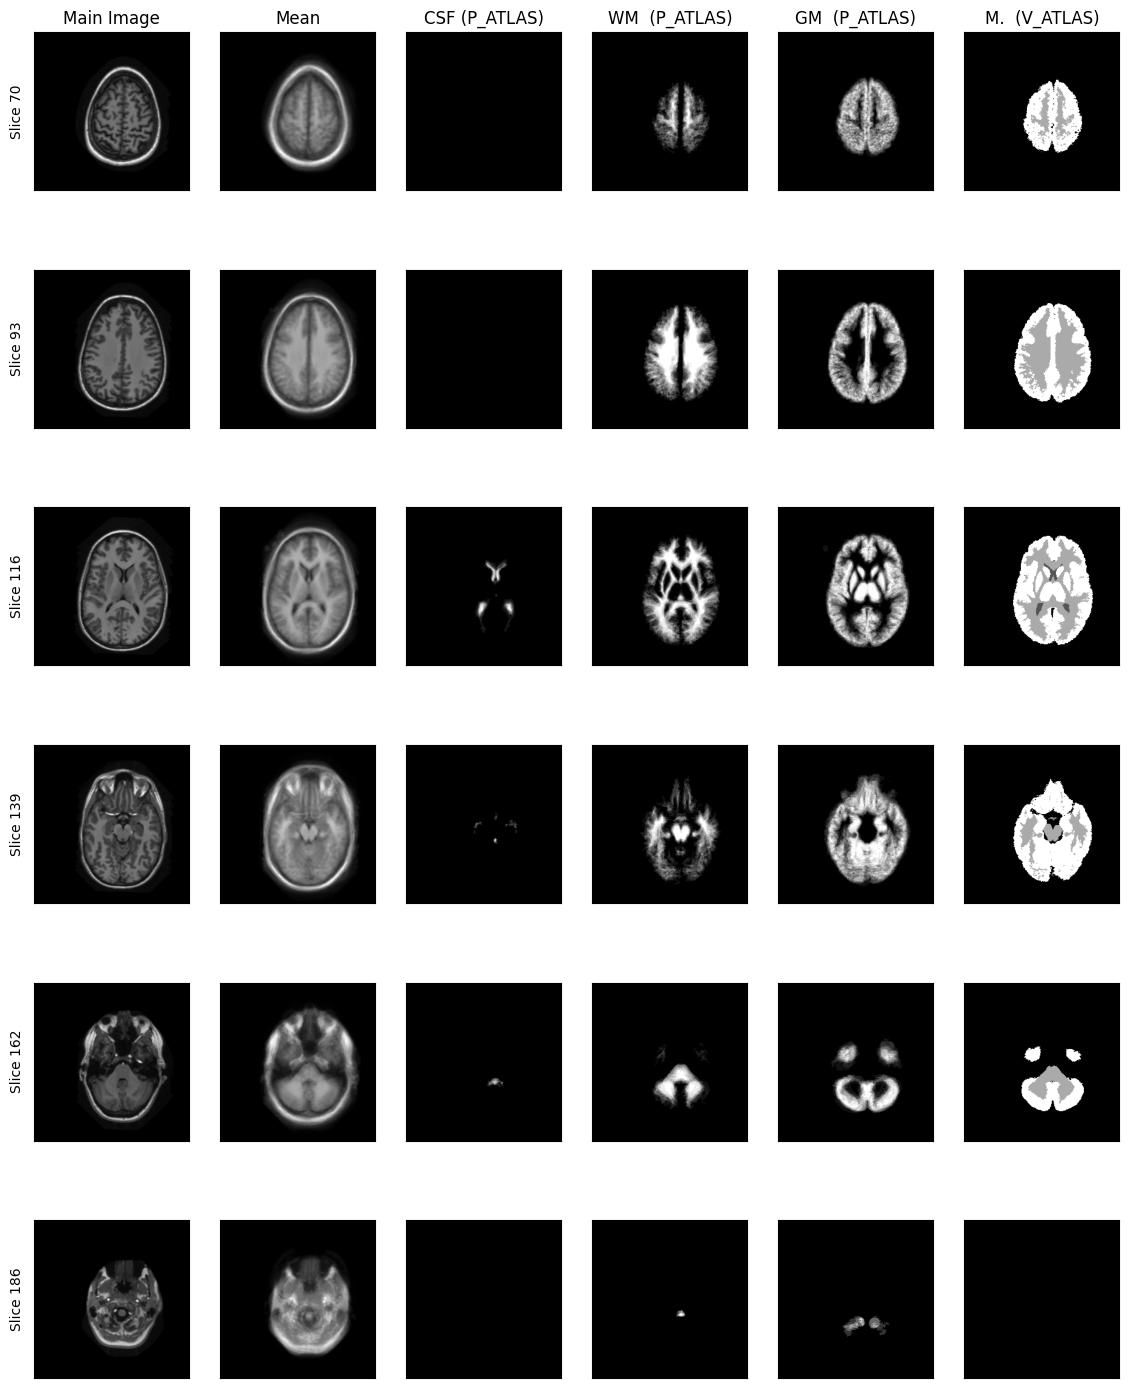

In [43]:
# Define paths and file names
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()
data_path = MAIN_PATH / 'Dataset' / 'Training'

image_names = [
    'training-images/1001.nii.gz',
    'Atlases/Par0009.affine/mean_volume.nii.gz',
    'Atlases/Par0009.affine/p_atlas_csf.nii.gz',
    'Atlases/Par0009.affine/p_atlas_wm.nii.gz',
    'Atlases/Par0009.affine/p_atlas_gm.nii.gz',
    'Atlases/Par0009.affine/t_atlas.nii.gz']

titles = [
    'Main Image',
    'Mean',
    'CSF (P_ATLAS)',
    'WM  (P_ATLAS)',
    'GM  (P_ATLAS)',
    'M.  (V_ATLAS)']

# Plot images
fig, ax = plt.subplots(6, len(image_names), figsize=(14, 18))

for i, slice_n in enumerate(np.linspace(70, (sitk.GetArrayFromImage(sitk.ReadImage(str(data_path / image_names[0]))).shape[0] - 70), 6).astype('int')):
    for j, img_name in enumerate(image_names):
        # Read the image and convert it to a NumPy array
        img = sitk.ReadImage(str(data_path / img_name))
        img_array = sitk.GetArrayFromImage(img)
        img_array = img_array[::-1, ::-1, ::-1]  # Flip the array for proper orientation

        # Set title for the first row
        if i == 0:
            ax[i, j].set_title(titles[j])

        # Display the image slice
        ax[i, j].imshow(img_array[slice_n, :, :], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        # Set ylabel for the first column
        if j == 0:
            ax[i, j].set_ylabel(f'Slice {slice_n}')

# Display the plot
plt.show()

**2. Tissue Model**

In [44]:
# Define the main paths
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()

# Define the path of registarted image and labels
output_dir_path     = MAIN_PATH / 'Dataset' / 'Training' / 'training-outputs' / 'Par0009.affine'
reg_image_dir_path  = output_dir_path / 'training-images'
reg_labels_dir_path = output_dir_path / 'training-labels'

# Define the path of atlas
atlases_dir_path    = MAIN_PATH / 'Dataset' / 'Training' / 'Atlases' / 'Par0009.affine'

# Define the path of reference image
ref_image_path = reg_image_dir_path / 'r_1001.nii.gz'

# Read the atlas and label
t_atlas     = sitk.GetArrayFromImage(sitk.ReadImage(str(atlases_dir_path/'t_atlas.nii.gz')))
gt_labels   = sitk.GetArrayFromImage(sitk.ReadImage(str(reg_labels_dir_path/'r_1001_3C.nii.gz')))

num_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'wm', 3: 'gm'}

t_histograms = np.zeros((4, 255))
gt_histograms = np.zeros((4, 255))

# Iterate through each registered image
for i, image_path in tqdm(enumerate(reg_image_dir_path.iterdir()), total=len(list(reg_image_dir_path.iterdir()))):
    if image_path.name.endswith('txt'):
        continue
    moving_image_id   = image_path.name.rstrip('.nii.gz')
    moving_label_path = reg_labels_dir_path / f'{moving_image_id}_3C.nii.gz'
    
    # Read and preprocess the moving image
    image_array = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image_array = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype('uint8')
    image_label = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_label_path)))

    # Compute histograms for each class
    for j in range(num_classes):
        t_histograms[j, :]  += np.histogram(image_array[t_atlas == j], bins=255, range=[0, 256])[0]
        gt_histograms[j, :] += np.histogram(image_array[image_label == j], bins=255, range=[0, 256])[0]

# Compute density histograms
t_histograms_density = t_histograms / np.sum(t_histograms, axis=1)[:, None]
gt_histograms_density = gt_histograms / np.sum(gt_histograms, axis=1)[:, None]

t_sum = np.sum(t_histograms_density, axis=0)[None, :]
gt_sum = np.sum(gt_histograms_density, axis=0)[None, :]

# Compute posterior histograms
t_histograms_posterior = t_histograms_density / np.repeat(t_sum, 4, axis=0)
gt_histograms_posterior = gt_histograms_density / np.repeat(gt_sum, 4, axis=0)


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:44<00:00,  1.52s/it]


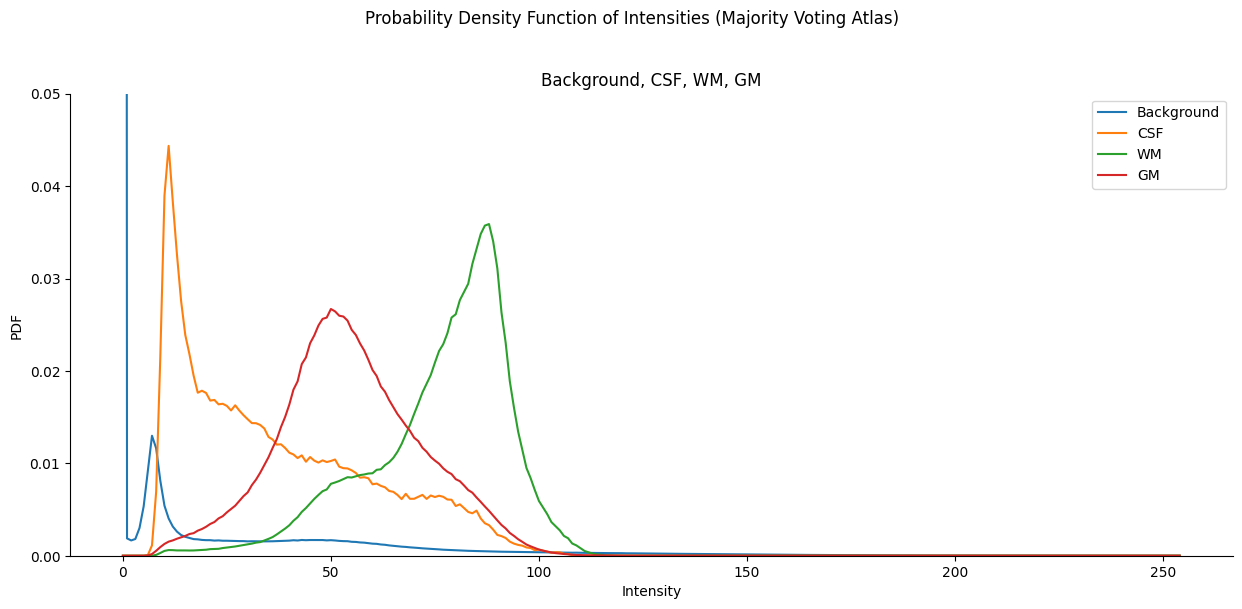

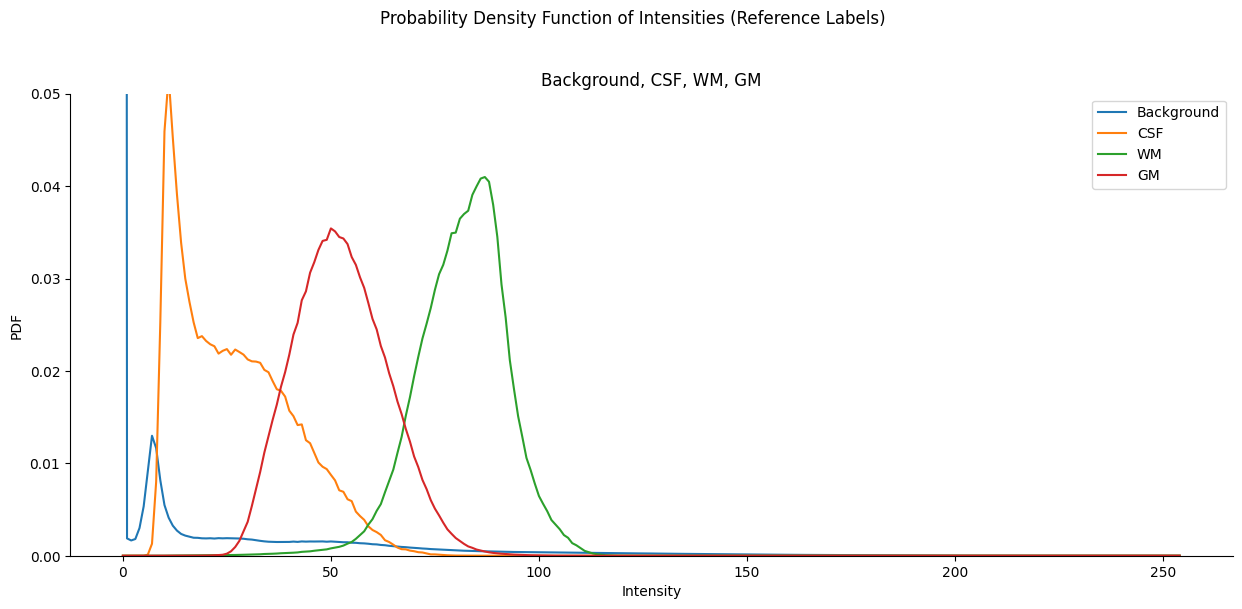

In [45]:
# Updated class names for better readability
labels_keys = {0: 'Background', 1: 'CSF', 2: 'WM', 3: 'GM'}

# Plotting Probability Density Functions (PDF) for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Majority Voting Atlas)', y=1.02)

for c in range(num_classes):
    plt.plot(t_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.05])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, WM, GM')
sns.despine()
plt.legend()
plt.show()

# Plotting Probability Density Functions (PDF) for each class based on Reference Labels
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Reference Labels)', y=1.02)

for c in range(num_classes):
    plt.plot(gt_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.05])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, WM, GM')
sns.despine()
plt.legend()
plt.show()


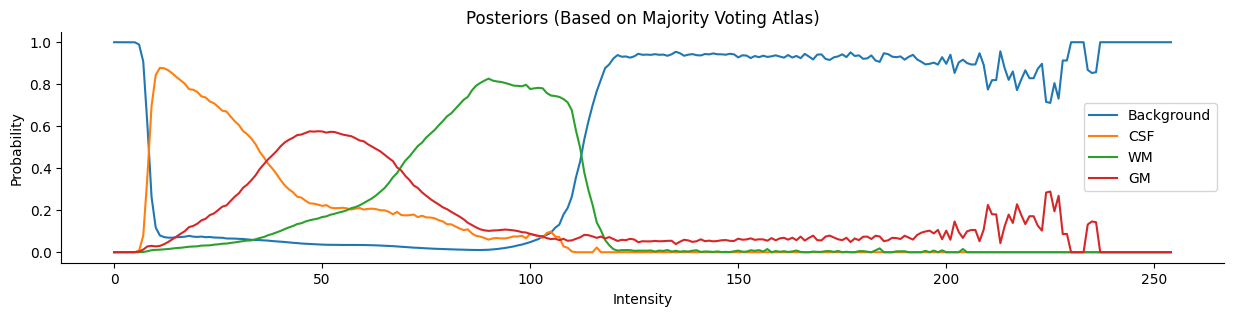

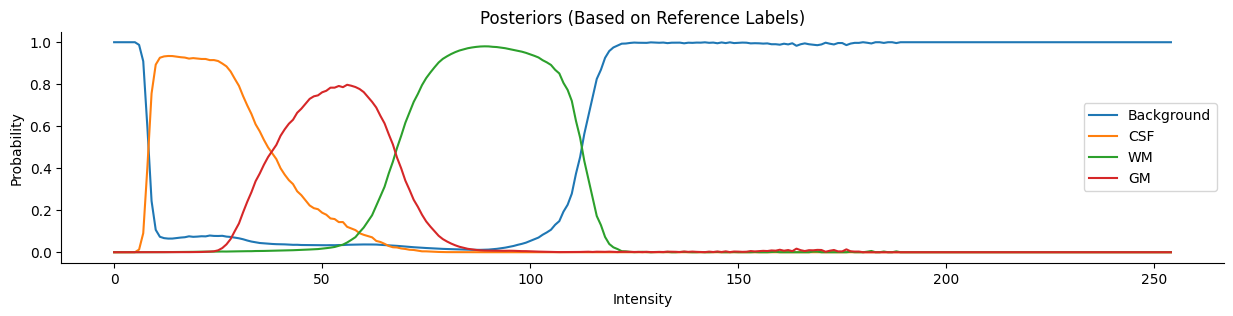

In [46]:
# Updated class names for better readability
labels_keys = {0: 'Background', 1: 'CSF', 2: 'WM', 3: 'GM'}

# Plotting Posteriors for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Majority Voting Atlas)')

for c in range(num_classes):
    plt.plot(t_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# Plotting Posteriors for each class based on Reference Labels
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Reference Labels)')

for c in range(num_classes):
    plt.plot(gt_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()


# BSpline Registration

**1. Generate ATLAS**

In [48]:
# Define all necessary paths
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()

# Define the path of registarted image and labels
output_dir_path     = MAIN_PATH / 'Dataset' / 'Training' / 'training-outputs' / 'Par0009.bspline'
reg_image_dir_path  = output_dir_path / 'training-images'
reg_labels_dir_path = output_dir_path / 'training-labels'

# Define the path of the reference image
ref_image_path = reg_image_dir_path / 'r_1001.nii.gz'

# Read the reference image and convert into an array
ref_image = sitk.ReadImage(str(ref_image_path))  
ref_image_array = sitk.GetArrayFromImage(ref_image)

# Define the configuration for atlas
num_classes = 4
num_volumes = len(list(reg_labels_dir_path.iterdir()))
ref_image_shape = ref_image_array.shape
labels_keys = {0: 'background', 1: 'csf', 2: 'wm', 3: 'gm'}

# Create atlas accumulators
atlases     = np.zeros((num_classes, ref_image_shape[0], ref_image_shape[1], ref_image_shape[2])).astype('float32')
mean_volume = np.zeros_like(ref_image_array).astype('float32')

# Loop through each registered image for atlas creation
for i, image_path in tqdm(enumerate(reg_image_dir_path.iterdir()), total=len(list(reg_image_dir_path.iterdir()))):
    
    # If image has .txt extension, continue
    if image_path.name.endswith('txt'):
        continue
    
    # Get the id of the registered image and label
    image_id = image_path.name.rstrip('.nii.gz')
    label_id = f'{image_id}_3C.nii.gz'
    
    # Accumulate the mean of an registered image
    image = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image = ((image - image.min()) / (image.max() - image.min()) * 255).astype('uint8')
    mean_volume += image / num_volumes
    
    # Accumulate probability atlas image
    label = sitk.GetArrayFromImage(sitk.ReadImage(str(reg_labels_dir_path / label_id))) 
    for j in range(atlases.shape[0]):
        atlases[j, :, :, :] += np.where(label == j, 1, 0) / num_volumes

# Get topological atlas by voting
topological_atlas = np.argmax(atlases, axis=0)

# Save atlas results
atlas_output_path = MAIN_PATH / 'Dataset' / 'Training' / "Atlases" / "Par0009.bspline"
atlas_output_path.mkdir(exist_ok=True, parents=True)

for k in range(atlases.shape[0]):
    save_atlas(atlases[k, :, :, :], ref_image, atlas_output_path / f'p_atlas_{labels_keys[k]}.nii.gz')
    save_atlas(np.where(topological_atlas == k, 255, 0), ref_image, atlas_output_path / f't_atlas_{labels_keys[k]}.nii.gz')

    save_atlas(topological_atlas, ref_image, atlas_output_path / 't_atlas.nii.gz')
    save_atlas(mean_volume, ref_image, atlas_output_path / 'mean_volume.nii.gz')

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:39<00:00,  1.38s/it]


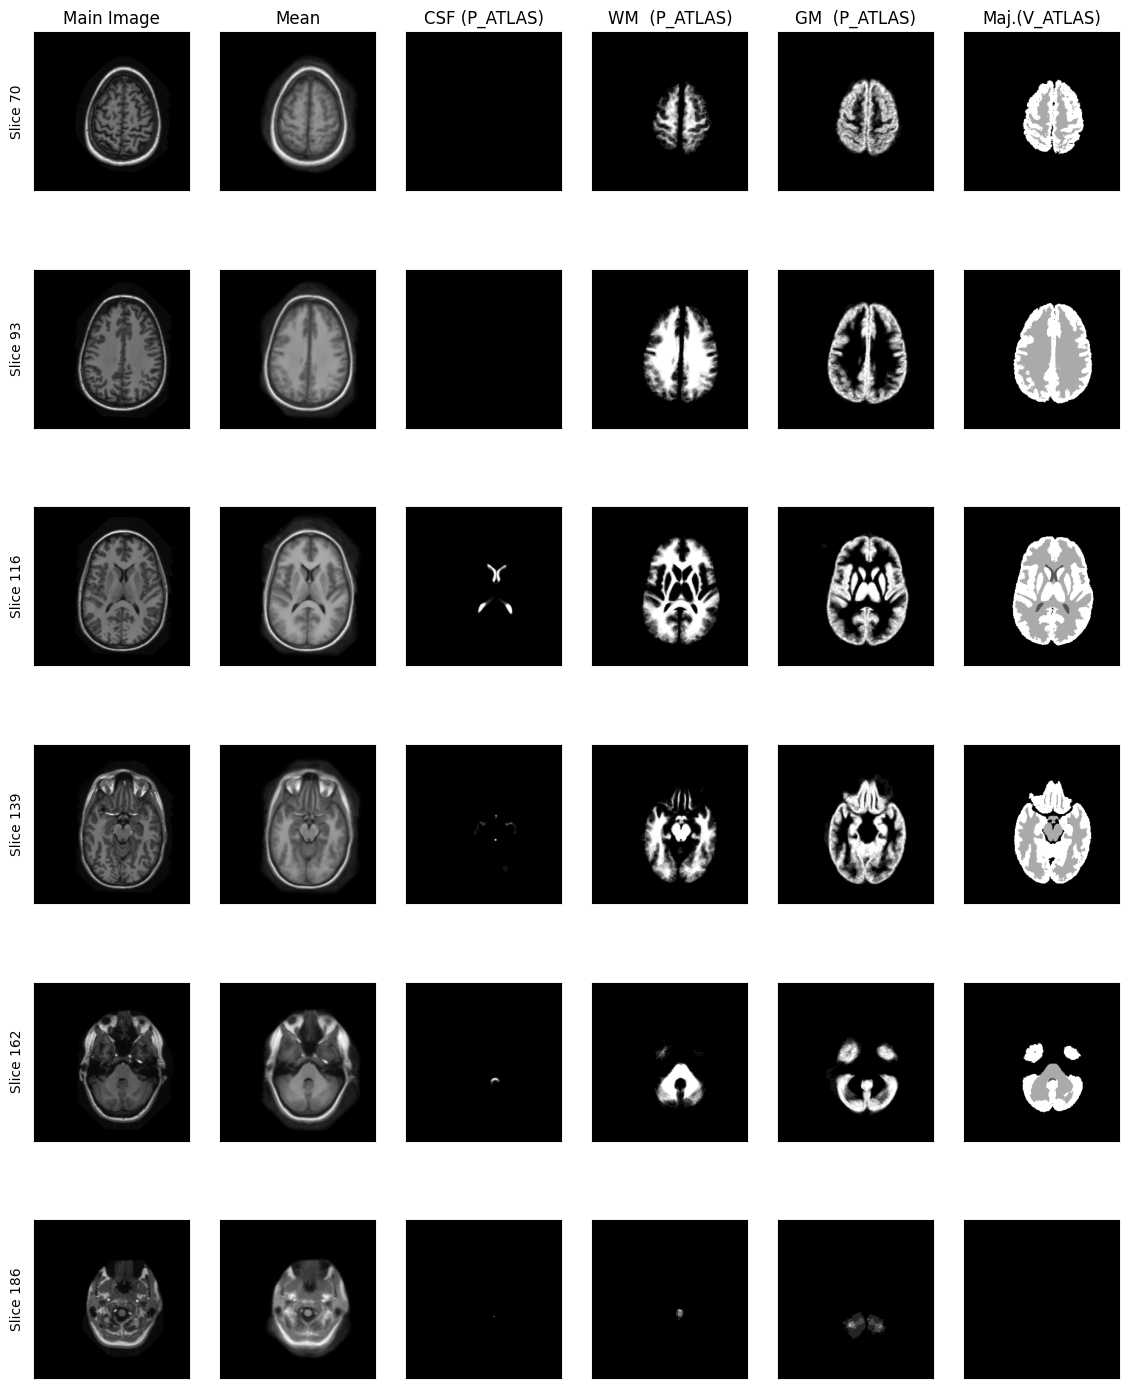

In [49]:
# Define the main paths
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()
data_path = MAIN_PATH / 'Dataset' / 'Training'

# Define the list of image names and titles
image_names = [
    'training-images/1001.nii.gz',
    'Atlases/Par0009.bspline/mean_volume.nii.gz',
    'Atlases/Par0009.bspline/p_atlas_csf.nii.gz',
    'Atlases/Par0009.bspline/p_atlas_wm.nii.gz',
    'Atlases/Par0009.bspline/p_atlas_gm.nii.gz',
    'Atlases/Par0009.bspline/t_atlas.nii.gz']

titles = [
    'Main Image',
    'Mean',
    'CSF (P_ATLAS)',
    'WM  (P_ATLAS)',
    'GM  (P_ATLAS)',
    'Maj.(V_ATLAS)']

# Plot images
fig, ax = plt.subplots(6, len(image_names), figsize=(14, 18))

# Loop over slices and image names
for i, slice_n in enumerate(np.linspace(70, (sitk.GetArrayFromImage(sitk.ReadImage(str(data_path / image_names[0]))).shape[0] - 70), 6).astype('int')):
    for j, img_name in enumerate(image_names):
        # Read the image and convert it to a NumPy array
        img = sitk.ReadImage(str(data_path / img_name))
        img_array = sitk.GetArrayFromImage(img)
        img_array = img_array[::-1, ::-1, ::-1]  # Flip the array for proper orientation

        # Set title for the first row
        if i == 0:
            ax[i, j].set_title(titles[j])

        # Display the image slice
        ax[i, j].imshow(img_array[slice_n, :, :], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        # Set ylabel for the first column
        if j == 0:
            ax[i, j].set_ylabel(f'Slice {slice_n}')

# Display the plot
plt.show()


**2. Tissue Model**

In [50]:
# Define all necessary paths
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()

# Paths for output, registered images, registered labels, and atlases
output_dir_path     = MAIN_PATH / 'Dataset' / 'Training' / 'training-outputs' / 'Par0009.bspline'
reg_image_dir_path  = output_dir_path / 'training-images'
reg_labels_dir_path = output_dir_path / 'training-labels'
atlases_dir_path    = MAIN_PATH / 'Dataset' / 'Training' / 'Atlases' / 'Par0009.bspline'

# Define the path of the reference image
ref_image_path = reg_image_dir_path / 'r_1001.nii.gz'

# Load the atlas and ground truth labels
t_atlas     = sitk.GetArrayFromImage(sitk.ReadImage(str(atlases_dir_path/'t_atlas.nii.gz')))
gt_labels   = sitk.GetArrayFromImage(sitk.ReadImage(str(reg_labels_dir_path/'r_1001_3C.nii.gz')))

# Define the number of classes and labels keys
num_classes = 4
labels_keys = {0: 'background', 1: 'csf', 2: 'wm', 3: 'gm'}

# Initialize histograms for the atlas (t) and ground truth (gt)
t_histograms = np.zeros((4, 255))
gt_histograms = np.zeros((4, 255))

# Iterate through each registered image
for i, image_path in tqdm(enumerate(reg_image_dir_path.iterdir()), total=len(list(reg_image_dir_path.iterdir()))):
    # Skip text files
    if image_path.name.endswith('txt'):
        continue
    # Extract the moving image ID and corresponding label path
    moving_image_id   = image_path.name.rstrip('.nii.gz')
    moving_label_path = reg_labels_dir_path / f'{moving_image_id}_3C.nii.gz'
    
    # Read the image and preprocess it
    image_array = sitk.GetArrayFromImage(sitk.ReadImage(str(image_path)))
    image_array = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype('uint8')
    image_label = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_label_path)))

    # Compute histograms for each class in the atlas (t) and ground truth (gt)
    for j in range(num_classes):
        t_histograms[j, :]  += np.histogram(image_array[t_atlas == j], bins=255, range=[0, 256])[0]
        gt_histograms[j, :] += np.histogram(image_array[image_label == j], bins=255, range=[0, 256])[0]

# Compute density histograms for the atlas (t) and ground truth (gt)
t_histograms_density = t_histograms / np.sum(t_histograms, axis=1)[:, None]
gt_histograms_density = gt_histograms / np.sum(gt_histograms, axis=1)[:, None]

# Compute sums for the atlas (t) and ground truth (gt)
t_sum = np.sum(t_histograms_density, axis=0)[None, :]
gt_sum = np.sum(gt_histograms_density, axis=0)[None, :]

# Compute posterior histograms for the atlas (t) and ground truth (gt)
t_histograms_posterior = t_histograms_density / np.repeat(t_sum, 4, axis=0)
gt_histograms_posterior = gt_histograms_density / np.repeat(gt_sum, 4, axis=0)


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:45<00:00,  1.59s/it]


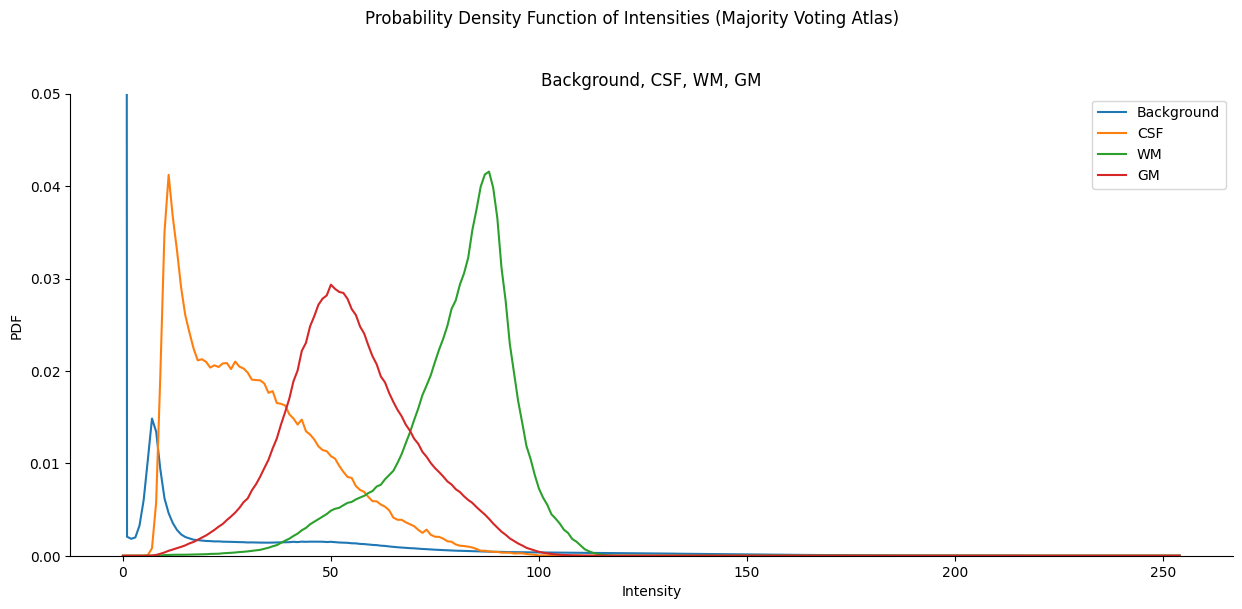

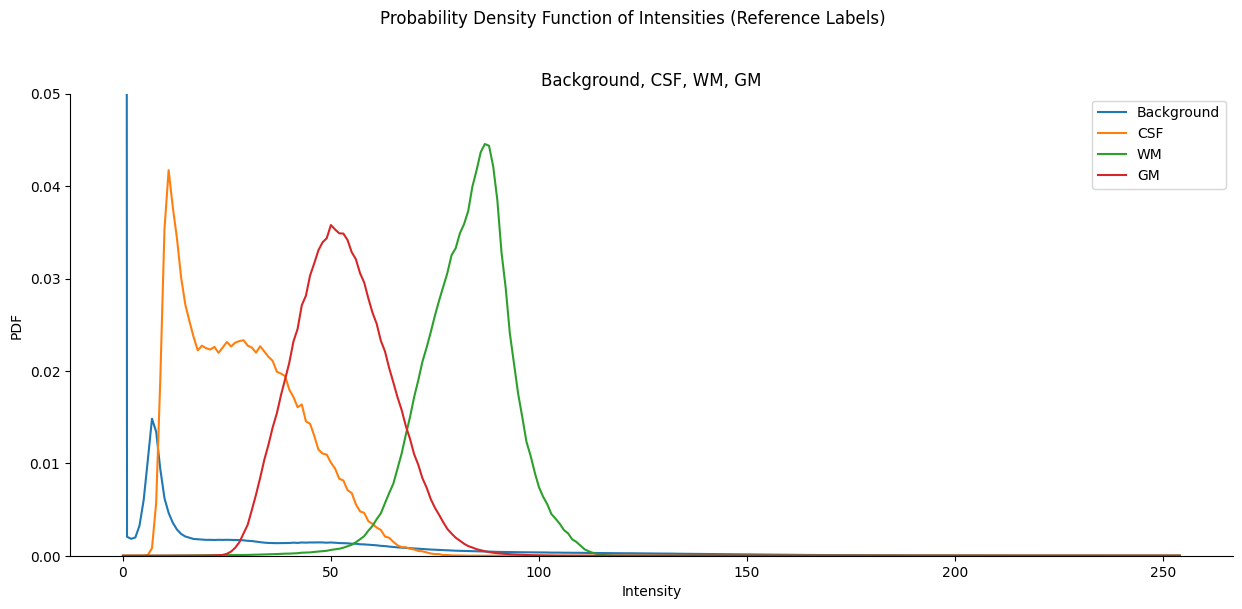

In [51]:
# Updated class names for better readability
labels_keys = {0: 'Background', 1: 'CSF', 2: 'WM', 3: 'GM'}

# Plotting Probability Density Functions (PDF) for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Majority Voting Atlas)', y=1.02)

for c in range(num_classes):
    plt.plot(t_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.05])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, WM, GM')
sns.despine()
plt.legend()
plt.show()

# Plotting Probability Density Functions (PDF) for each class based on Reference Labels
plt.figure(figsize=(15, 6))
plt.suptitle('Probability Density Function of Intensities (Reference Labels)', y=1.02)

for c in range(num_classes):
    plt.plot(gt_histograms_density[c, :], label=labels_keys[c])

plt.ylim([0, 0.05])
plt.ylabel('PDF')
plt.xlabel('Intensity')
plt.title('Background, CSF, WM, GM')
sns.despine()
plt.legend()
plt.show()

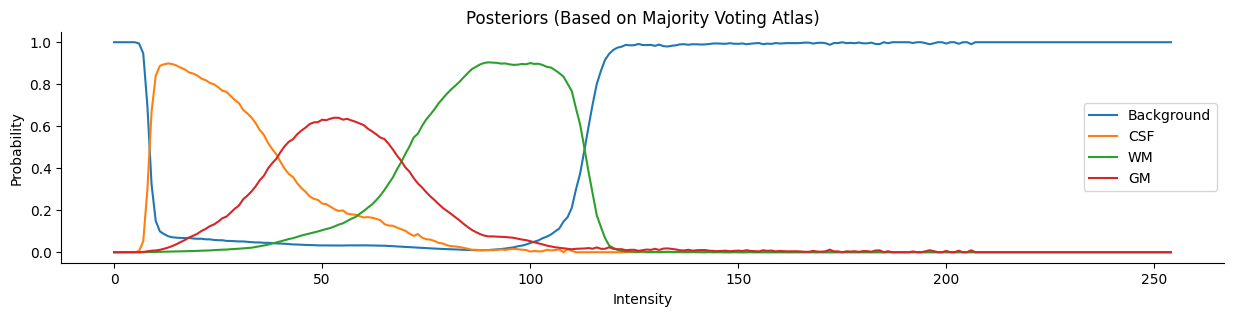

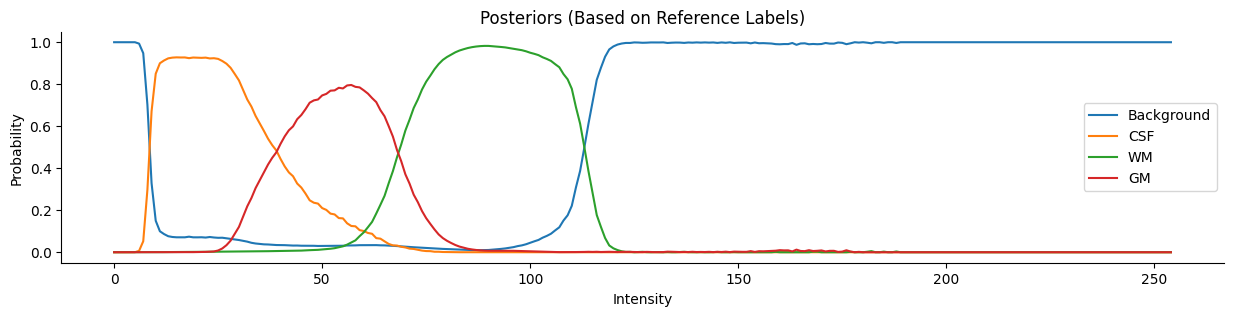

In [52]:
# Updated class names for better readability
labels_keys = {0: 'Background', 1: 'CSF', 2: 'WM', 3: 'GM'}

# Plotting Posteriors for each class based on Majority Voting Atlas
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Majority Voting Atlas)')

for c in range(num_classes):
    plt.plot(t_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()

# Plotting Posteriors for each class based on Reference Labels
plt.figure(figsize=(15, 3))
plt.title('Posteriors (Based on Reference Labels)')

for c in range(num_classes):
    plt.plot(gt_histograms_posterior[c, :], label=labels_keys[c])

plt.ylabel('Probability')
plt.xlabel('Intensity')
sns.despine()
plt.legend()
plt.show()


**3. Mutul Information**

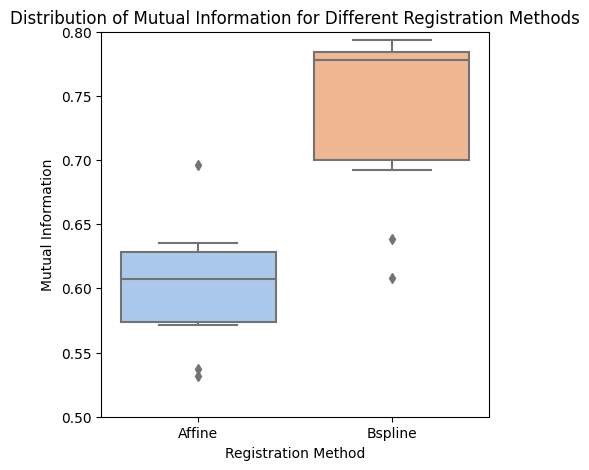

In [26]:
# Define all necessary paths
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()

ref_image_path = MAIN_PATH / 'Dataset' / 'Training' / 'training-images' / '1001.nii.gz'
ref_image = sitk.GetArrayFromImage(sitk.ReadImage(str(ref_image_path)))

# List of registration parameters and corresponding paths
registration_parameters = ['Par0009.affine', 'Par0009.bspline']

# Initialize lists to store mutual information and registration methods
mutual_info_df = []
method_df = []

# Loop through different registration parameters
for reg_parameter in registration_parameters:
    # Construct the registration image path based on the registration parameter
    reg_image_path = MAIN_PATH / 'Dataset' / 'Training' / 'training-outputs' / reg_parameter / 'training-images'
    
    # Loop through each moving image in the registration path
    for moving_image_path in reg_image_path.iterdir():
        if moving_image_path.name.endswith('txt'):
            continue
        
        # Read the moving image
        moving_image = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_image_path)))
        
        # Calculate mutual information directly
        hist_2d, _, _ = np.histogram2d(ref_image.ravel(), moving_image.ravel(), bins=255)
        pxy = hist_2d / float(np.sum(hist_2d))
        px = np.sum(pxy, axis=1)
        py = np.sum(pxy, axis=0)
        px_py = px[:, None] * py[None, :]
        nzs = pxy > 0
        mutual_info = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
        
        # Append mutual information and registration method to the lists
        mutual_info_df.append(mutual_info)
        method_df.append(reg_parameter)

# Create a DataFrame from the collected data
data = {'Method': method_df, 'MI': mutual_info_df}
mutual_information_df = pd.DataFrame(data)

# Plotting box plot with adjusted height and labels
plt.figure(figsize=(5, 5))
sns.boxplot(x='Method', y='MI', data=mutual_information_df, whis=[10, 90], palette='pastel')
plt.title('Distribution of Mutual Information for Different Registration Methods')
plt.xlabel('Registration Method')
plt.ylabel('Mutual Information')
plt.ylim([0.5, 0.8])
plt.xticks([0, 1], ['Affine', 'Bspline'])
plt.show()


**4. Vizualization**

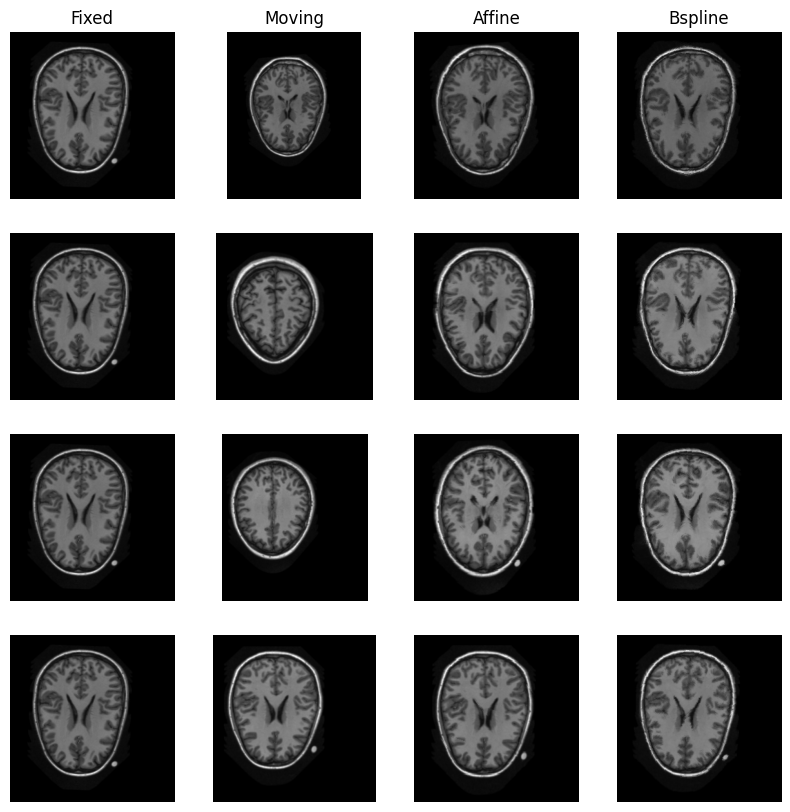

In [37]:
# Define the main paths
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()
dataset_path = MAIN_PATH / 'Dataset' / 'Training'

# Define the image IDs
image_ids = ['1007', '1008', '1009', '1010']

# Lists to store images and labels for different transformations
images = []
labels = []
images_afine = []
labels_afine = []
images_bspline = []
labels_bspline = []

# Iterate over image IDs to load images and labels for different transformations
for s in image_ids:
    # Original images and labels
    images.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / 'training-images' / f'{s}.nii.gz'))))
    labels.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / 'training-labels' / f'{s}_3C.nii.gz'))))
    
    # Affine transformed images and labels
    images_afine.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / 'training-outputs' / 'Par0009.affine' / 'training-images' / f'r_{s}.nii.gz'))))
    labels_afine.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / 'training-outputs' / 'Par0009.affine' / 'training-labels' / f'r_{s}_3C.nii.gz'))))
    
    # Bspline transformed images and labels
    images_bspline.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / 'training-outputs' / 'Par0009.bspline' / 'training-images' / f'r_{s}.nii.gz'))))
    labels_bspline.append(sitk.GetArrayFromImage(sitk.ReadImage(str(dataset_path / 'training-outputs' / 'Par0009.bspline' / 'training-labels' / f'r_{s}_3C.nii.gz'))))

# Plot images
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

# Loop through the rows
for i in range(4):
    if i == 0:
        ax[i, 0].set_title(f'Fixed')
        ax[i, 1].set_title(f'Moving')
        ax[i, 2].set_title(f'Affine')
        ax[i, 3].set_title(f'Bspline')
        
    # Display the reference image
    ax[i][0].imshow(ref_image[150, :, :], 'gray')
    ax[i][0].axis('off')
    
    # Display the original image
    ax[i][1].imshow(images[i][150, :, :], 'gray')
    ax[i][1].axis('off')
    
    # Display the affine transformed image
    ax[i][2].imshow(images_afine[i][150, :, :], 'gray')
    ax[i][2].axis('off')
    
    # Display the bspline transformed image
    ax[i][3].imshow(images_bspline[i][150, :, :], 'gray')
    ax[i][3].axis('off')
    
# Adjust the layout
plt.subplots_adjust()
plt.show()
